In [1]:
using Plots
pythonplot()
# using PyPlot
using JLD2 
using LinearAlgebra
using LaTeXStrings
using CurveFit


# include("../../Helpers/FermionAlgebra.jl");
# using .FermionAlgebra;

include("../../Hamiltonians/H2.jl")
using .H2

include("../../Hamiltonians/H4.jl")
using .H4

include("../../Hamiltonians/Hgoe.jl")
using .Hgoe

include("../../Helpers/ChaosIndicators.jl");
using .ChaosIndicators;

include("../../Helpers/OperationsOnHamiltonian.jl");
using .OperationsOnH


colors = [:dodgerblue :darkviolet :limegreen :indianred :magenta :darkblue :aqua :deeppink :dimgray :red :royalblue :slategray :black :lightseagreen :forestgreen :palevioletred]

1×16 Matrix{Symbol}:
 :dodgerblue  :darkviolet  :limegreen  …  :forestgreen  :palevioletred

Function saves normalization for each L in JLD2 file.

In [7]:
function GetNormalizationData(L′s:: Vector{Int}, maxNumbOfIter:: Int64, namespace:: Module)
    numericalNorm = zeros(Float64, (length(L′s), maxNumbOfIter));

    for (l, L) in enumerate(L′s)
        println("\nline L: ", L);
        for i=1:maxNumbOfIter
            if mod(i,20)==0
                print(" ", round(i/maxNumbOfIter *100, digits=2), "%..." );
            end
            params = namespace.Params(L);
            H₂ = namespace.Ĥ(params);

            numericalNorm[l,i] = OperationsOnH.OperatorNorm(H₂);
        end

        numericalNormByIteration = [ sum(numericalNorm[l,1:i])/i for i in 1:maxNumbOfIter ]

        folder = jldopen("./Data/Norm_$(namespace)_L$(L)_$(maxNumbOfIter)-Normalization.jld2", "w");
        folder["numericalNorm"] = numericalNorm[l,:];
        folder["numericalNormByIteration"] = numericalNormByIteration;
        close(folder);

    end
    
end

GetNormalizationData (generic function with 1 method)

In [8]:
L′s = [14];
maxNumbOfIter = 13000;
namespace = H2

# GetNormalizationData(L′s, maxNumbOfIter, namespace)


Main.H2

In [4]:
L′s = [4,6,8,10,12];
maxNumbOfIter = 5000;
namespace = H4

# GetNormalizationData(L′s, maxNumbOfIter, namespace)


Main.H4

In [5]:
L′s = [4,6,8,10];
maxNumbOfIter = 1000;
namespace = Hgoe

# GetNormalizationData(L′s, maxNumbOfIter, namespace)


Main.Hgoe

Function plots normalization for given parameters

In [62]:
function PlotNormalizationData(L′s, maxNumbOfIter, namespace)
    normAsFunctionOfIterations1 = plot( 
        yscale=:log10, 
        minorgrid=true, 
        framestyle = :box, 
        legend=:topleft, 
        # title = "Convergency of normalization error, w.r.t. last value", 
        xtickfont=font(12), 
        ytickfont=font(12), 
        guidefont=font(10), 
        legendfont=font(10)
    );
    normAsFunctionOfIterations2 = plot( 
        yscale=:log10, 
        minorgrid=true, 
        framestyle = :box, 
        legend=:topleft, 
        # title = "Convergency of normalization error, w.r.t. last value", 
        xtickfont=font(10), 
        ytickfont=font(10), 
        guidefont=font(10), 
        legendfont=font(10)
    );
    normAsFunctionOfSystemSize = plot(  
        yscale = :log10,
        framestyle = :box,
        # title="Normalization error",
        xtickfont=font(10), 
        ytickfont=font(10), 
        guidefont=font(10), 
        legendfont=font(10),
    );

    normaOfL = Vector{Float64}(undef, length(L′s));


    for (i,L) in enumerate(L′s)
        folder = jldopen("./Data-Normalization/Norm_$(namespace)_L$(L)_$(maxNumbOfIter).jld2", "r");
        numericalNorm = folder["numericalNorm"];
        numericalNormByIteration = folder["numericalNormByIteration"];
        close(folder);

        σ = std(numericalNorm)
        print(round(σ, digits=5), " & ")


        normaOfL[i] = abs(numericalNormByIteration[end] .- 1);


        plot!(normAsFunctionOfIterations1, 1:maxNumbOfIter-1, abs.(numericalNormByIteration[1:end-1] .- numericalNormByIteration[end]), lc=colors[i], label="L=$(L)");
        plot!(normAsFunctionOfIterations2, 1:maxNumbOfIter, abs.(numericalNormByIteration .- 1), lc=colors[i], label="L=$(L)");
        scatter!(normAsFunctionOfSystemSize, [L], [abs(numericalNormByIteration[end] .- 1)], yerr= [σ],  mc=:dodgerblue, label="");
    end

    ylims!(normAsFunctionOfSystemSize, (0.00001,0.1))

    

    fit = linear_fit(L′s, log10.(normaOfL))
    y10 = fit[1] .+ fit[2] .* L′s;
    y= 10 .^y10
    println(y)
    println(fit)

    plot!(normAsFunctionOfSystemSize, L′s, y, legend=true, label =L"%$(round(fit[1], digits=3))\exp(%$(round(fit[2], digits=3))\;L)", lc=colors[1]);

    xlabel!(normAsFunctionOfIterations1, "Number of Iterations");
    ylabel!(normAsFunctionOfIterations1, L"\vert\vert H_{GOE} \vert\vert - last value");
    xlabel!(normAsFunctionOfIterations2, "Number of Iterations");
    ylabel!(normAsFunctionOfIterations2, L"\delta \vert\vert H_{GOE} \vert\vert");
    xlabel!(normAsFunctionOfSystemSize,  L"L");
    ylabel!(normAsFunctionOfSystemSize, L"\delta \vert\vert H_{GOE} \vert\vert");

    ratio = 3
    dim = 500
    p = plot(normAsFunctionOfIterations1, normAsFunctionOfIterations2, normAsFunctionOfSystemSize, layout=(1,3), size=(Int(dim*ratio),dim))
    savefig(p, "./Images-Normalization/Normalization_$(namespace)_L$(L′s)_$(maxNumbOfIter).pdf")    

end 

PlotNormalizationData (generic function with 1 method)

0.24166 & 0.16403 & 0.1221 & 0.09813 & 0.0809 & 0.06982 & [0.021411477568088352, 0.013878205594265978, 0.008995389968031588, 0.005830511742122893, 0.0037791432384639387, 0.002449514596402759]
(-1.2927267191776752, -0.09415666065047205)


sys:1: UserWarning: You passed a edgecolor/edgecolors (<jl [0.0, 0.0, 0.0, 1.0]>) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


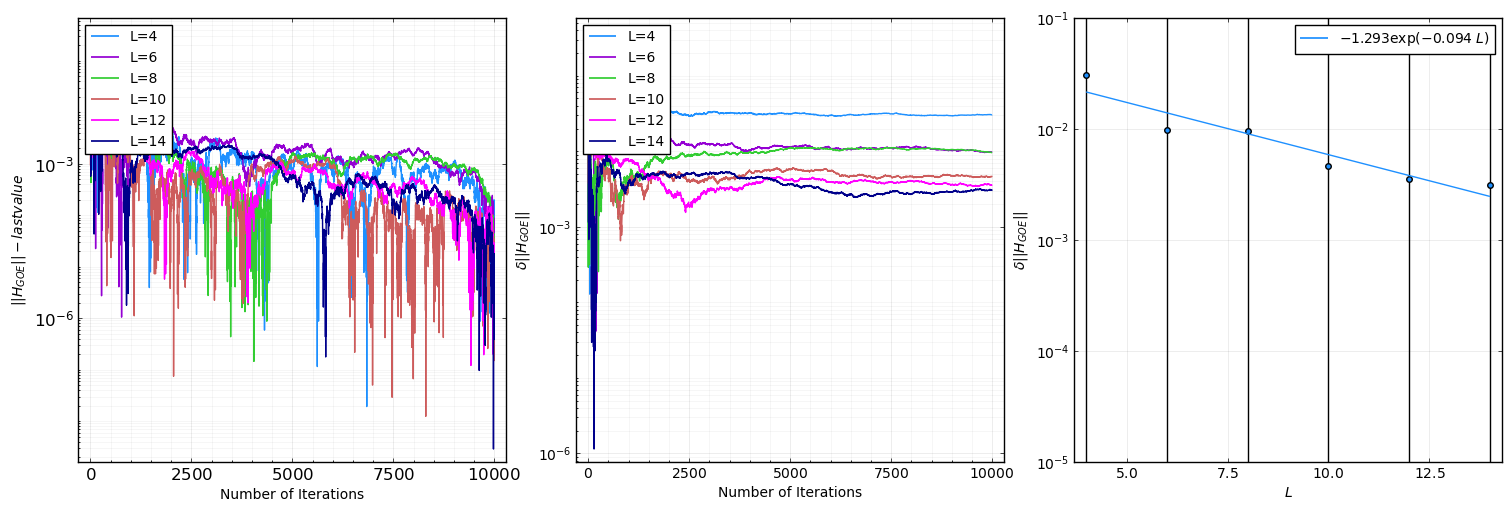

"/Users/rokpintar/Desktop/FAX/MAG 2. /Magisterska naloga/Magisterska-Naloga-Program/MastersDegree/Plotting/Normalization/Images-Normalization/Normalization_Main.H2_L[4, 6, 8, 10, 12, 14]_10000.pdf"

In [63]:
L′s = [4,6,8,10,12,14];
maxNumbOfIter = 10000;
namespace = H2

PlotNormalizationData(L′s, maxNumbOfIter, namespace)

0.16226 & 0.07316 & 0.04458 & 0.03074 & 0.02226 & [0.009960390620777642, 0.003982265755249212, 0.0015921504636926026, 0.0006365579935731674, 0.0002545023780240722]
(-1.205431366333064, -0.19907306575052586)


sys:1: UserWarning: You passed a edgecolor/edgecolors (<jl [0.0, 0.0, 0.0, 1.0]>) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


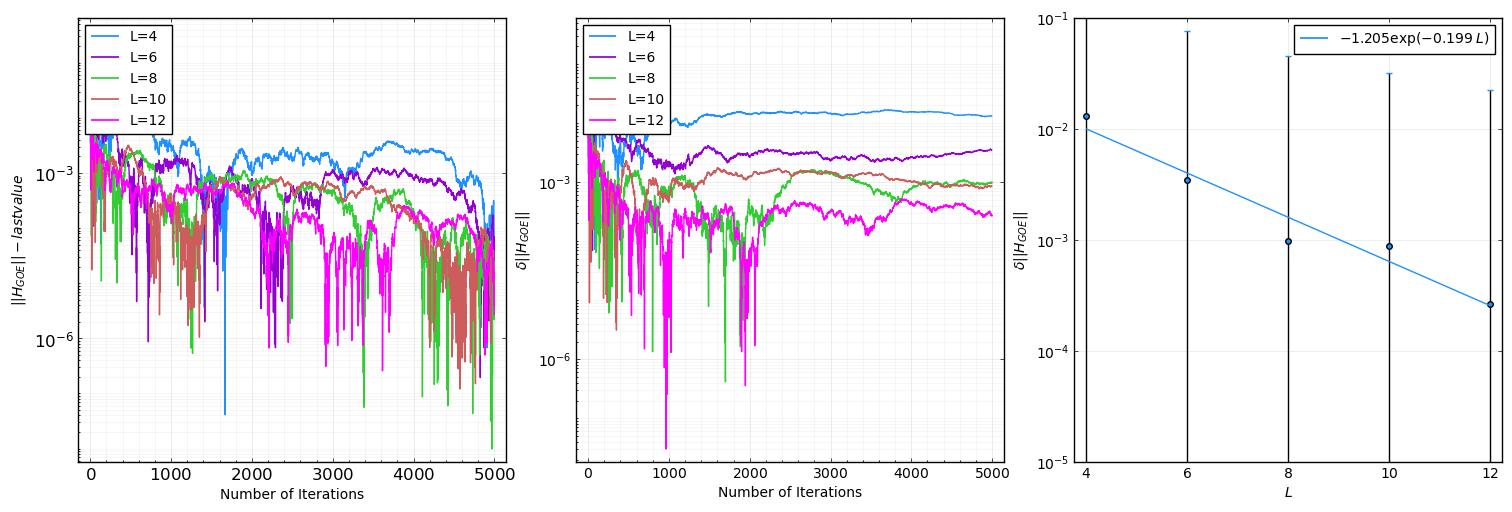

"/Users/rokpintar/Desktop/FAX/MAG 2. /Magisterska naloga/Magisterska-Naloga-Program/MastersDegree/Plotting/Normalization/Images-Normalization/Normalization_Main.H4_L[4, 6, 8, 10, 12]_5000.pdf"

In [64]:
namespace = H4;
L′s = [4,6,8,10,12];
maxNumbOfIter = 5000;

PlotNormalizationData(L′s, maxNumbOfIter, namespace)


0.05899854362856946
0.015590193935506057
0.003921838464280259
0.0009679579473607852
[0.0029314307082767554, 0.00042884138421106754, 6.273555513108914e-5, 9.177635420719628e-6]
(-0.8633544793043143, -0.4173914719234467)


sys:1: UserWarning: You passed a edgecolor/edgecolors (<jl [0.0, 0.0, 0.0, 1.0]>) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


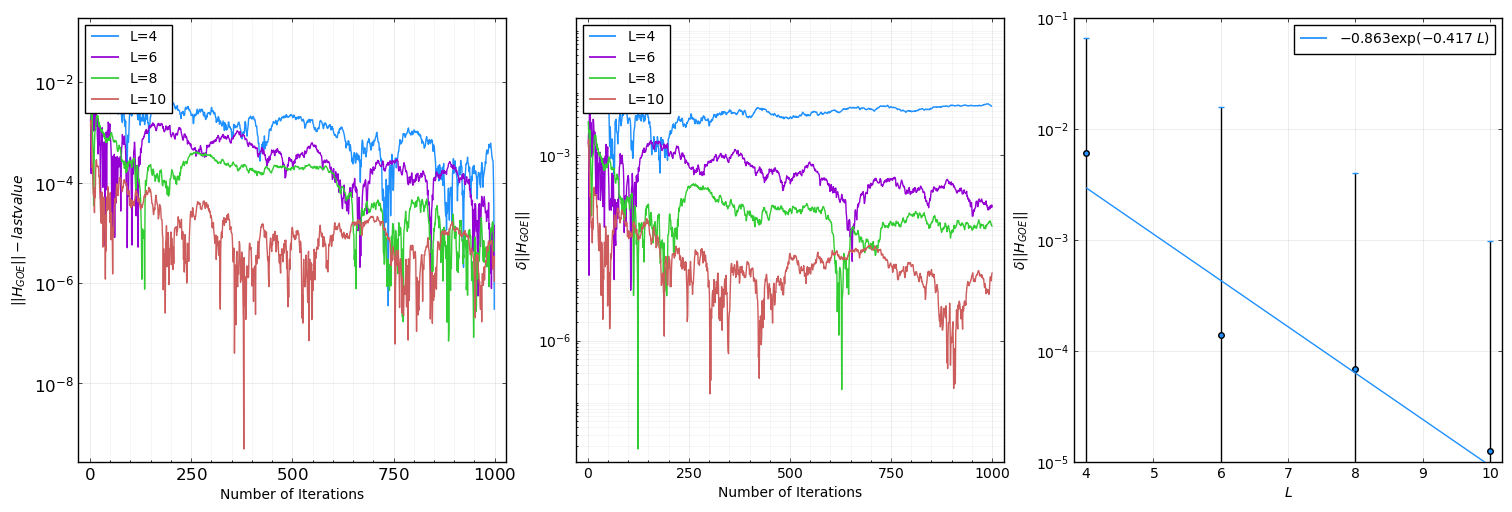

"/Users/rokpintar/Desktop/FAX/MAG 2. /Magisterska naloga/Magisterska-Naloga-Program/MastersDegree/Plotting/Normalization/Images-Normalization/Normalization_Main.Hgoe_L[4, 6, 8, 10]_1000.pdf"

In [58]:
L′s = [4,6,8,10];
maxNumbOfIter = 1000;
namespace = Hgoe

PlotNormalizationData(L′s, maxNumbOfIter, namespace)


In [10]:
function JoinTwoNormalizationFiles(L′s, maxNumbOfIter1, maxNumbOfIter2, namespace)
    
    for L in L′s
        folder1 = jldopen("./Data/Norm_$(namespace)_L$(L)_$(maxNumbOfIter1).jld2", "r");
        numericalNorm1 = folder1["numericalNorm"];
        numericalNormByIteration2 = folder1["numericalNormByIteration"];
        close(folder1);
        
        # folder2 = jldopen("./Data/Norm_$(namespace)_L$(L)_$(maxNumbOfIter2)_true.jld2", "r");
        # numericalNorm2 = folder2["numericalNorm"];
        # numericalNormByIteration2 = folder2["numericalNormByIteration"];
        # close(folder2);

        maxNumbOfIter = maxNumbOfIter1 + maxNumbOfIter2;
        numericalNorm = numericalNorm1[1:maxNumbOfIter] #vcat(numericalNorm1, numericalNorm2);
        numericalNormByIteration = [ sum(numericalNorm[1:i])/i for i in 1:maxNumbOfIter ];

        folder = jldopen("./Data/Norm_$(namespace)_L$(L)_$(maxNumbOfIter).jld2", "w");
        folder["numericalNorm"] = numericalNorm;
        folder["numericalNormByIteration"] = numericalNormByIteration;
        close(folder);
    end
end

# L′s = [4, 6, 8, 10, 12, 14];
# maxNumbOfIter1 = 13000;
# maxNumbOfIter2 = -3000;
# namespace = H2

# JoinTwoNormalizationFiles(L′s, maxNumbOfIter1, maxNumbOfIter2, namespace)

In [ ]:
# WORK IN PROGRESS

L′s = [4];
namespace = Hgoe

H²′s = Vector{Matrix{Float64}}(undef, length(L′s));

hᵢᵢ² = Vector{Float64}(undef, length(L′s))
hᵢⱼ² = Vector{Float64}(undef, length(L′s))

for (i,L) in enumerate(L′s)
    params = Hgoe.Params(L)
    H = Hgoe.Ĥ(params)
    H²′s[i] = H^2;

    display(H²′s[i])
    println("\n\n\n")
    display(Diagonal(H²′s[i]))

    D = size(H,1)
    hᵢᵢ²[i] = sum(Diagonal(H²′s[i]))/D
    hᵢⱼ²[i] = sum(H²′s[i] .- Diagonal(H²′s[i]))/(D*(D-1))
end

println(hᵢᵢ²)
println(hᵢⱼ²)



15.512621589255266


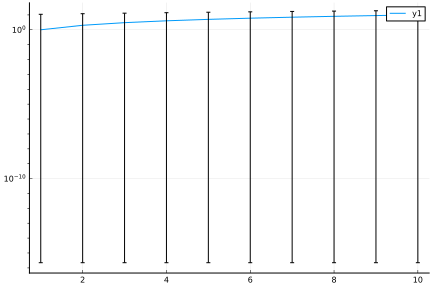

In [34]:
using Statistics

X = [1,2,3.3,44,3,3,11]

a = std(X);
println(a)



x = 1:10
y= x 
plot(x,y, yerr = [10], yscale=:log10)
